In [1]:
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets

from classifiers.externalGAN import Discriminator, Generator
from data_utils_NerveNet import SegmentationData
from solver_externalGAN import Solver
import transform_utils_NerveNet as tu
from dice_loss import DiceLoss

%load_ext autoreload
%autoreload 2

### Define and Divide Dataset
The following calculates the **sizes of train, validation and test set**. Make sure it returns **True** by modifying the values in the dictionary 'nums'.

In [2]:
img_files = 'image_files.txt' 
num_lines = sum(1 for line in open(img_files, 'r'))
num_lines = sum(1 for line in open(img_files, 'r'))
nums = {'num_train' : int(0.6*num_lines)+2,
        'num_val'   : int(0.2*num_lines),
        'num_test' : int(0.2*num_lines)}

print(nums, num_lines)
print(np.sum(list(nums.values())) == num_lines)

{'num_train': 1278, 'num_val': 425, 'num_test': 425} 2128
True


### 1. Train Nervenet without binary influence on dataset that contains only masked images.
Therefore, freeze all weights of model.binary and set train_data argument mask_only to true. The idea behind this is that the encoding stage can properly find filters for detecting nerves.

#### 1.1 Freeze Binary Output and Encoder Layers.

In [3]:
input_dim = (1, 128, 128)
model = torch.load("models/NerveNet+b_best.model", map_location=lambda storage, loc: storage)
#model = NerveNET(input_dim, weight_scale = True)
#model = torch.load("models/SegNet.model")
#model.binary_out = True

/usr/lib64/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'classifiers.NerveNet.NerveNET' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
discr_model = Discriminator(input_dim, weight_scale = True, dropout = 0.05)
gen_model = Generator(input_dim, weight_scale = True, dropout = 0.05)

#### 1.2 Initialize Dataloader with masked images only

In [5]:
#be aware about how these are set
binary_out = True 
mask_only = True

train_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.RandomHorizontalFlip(),
                               tu.RandomVerticalFlip(),                               
                               tu.ToTensor()])

train_data = SegmentationData(img_files, transform = train_transforms, mode = 'train', **nums, 
                              binary_out = binary_out, mask_only = mask_only)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=2,
                                           shuffle=True,
                                           num_workers=1)

#### 1.3 Train Classifier

START TRAIN.
|Iteration 10/3195| TRAIN loss GEN/DISCR: 0.482 / 0.551 || DISCRout REAL / FAKE / GEN: 0.559 / 0.081 / 0.411


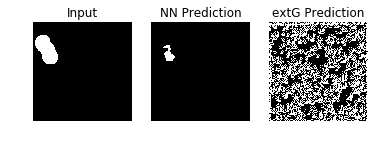

|Iteration 20/3195| TRAIN loss GEN/DISCR: 0.710 / 0.171 || DISCRout REAL / FAKE / GEN: 0.957 / 0.077 / 0.021


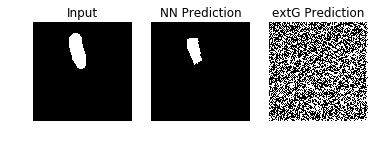

|Iteration 30/3195| TRAIN loss GEN/DISCR: 0.989 / 0.016 || DISCRout REAL / FAKE / GEN: 0.979 / 0.009 / 0.010


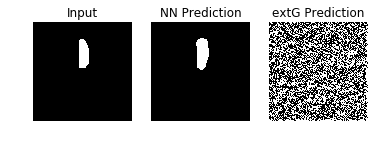

Process Process-1:
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

In [6]:
model.binary_out = False
model.train()

solver = Solver(gen_optim_args={"lr": 0.0005, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.001},
                discr_optim_args={"lr": 0.00025, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.001},
                loss_func = torch.nn.MSELoss())


outputs = solver.train(model, gen_model, discr_model, train_loader, log_nth=10, num_epochs=5)

### Test your Model

In [ ]:
#Initialize Dataloader
input_dim = (1, 128, 128)
val_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.ToTensor()])
test_data = SegmentationData(img_files,  transform = val_transforms, mode = 'test', **nums)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

In [ ]:
model.binary_out = True

#### Plot Single Image

In [ ]:
model.eval()

img, targets = test_data[99]

target = targets['main']
inputs = img.unsqueeze(0)
inputs = Variable(inputs)

model=model.cpu()

outputs = model.forward(inputs)
pred = outputs['main']
_, pred = torch.max(pred, 1)
binary_probs, binary = torch.max(outputs['binary'], 1)

#Comment/Uncomment to enable/disable binary classication
if binary.data.numpy() == 0:
    pred = pred * 0
    
pred = pred.squeeze().data.cpu().numpy()
img=np.squeeze(img)
target = target.squeeze().numpy()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(target)
ax[1].axis('off')
ax[2].imshow(pred)
ax[2].axis('off')
plt.show()

#### Are the binary probabilites making sense?
I found it was quite balanced if both values were around 50%. Therefore, train with classweights = [0.25, 0.75] for 5 epochs at least.

In [ ]:
outputs['binary']

### Visualize many Images

Set num_example_imgs to whatever you want and modify the slice in test_data[from:to] accordingly.

#### ToDo:
1. Border overlay of mask over image.
2. Filter plots, weights dreaming.
3. ...


In [ ]:
num_example_imgs = 20
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, targets) in enumerate(test_data[70:90]):
    
    target = targets['main']
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)

    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    binary_probs, binary = torch.max(outputs['binary'], 1)
    
    #If binary predicts no nerve we just multiply the predicted image with zeros.
    #Comment/Uncomment and plot to compare with/without of binary classification
    if binary.data.numpy() == 0:
        pred = pred * 0
        
    pred = pred.squeeze().data.cpu().numpy()

    img=np.squeeze(img)
    target = target.squeeze().numpy()
        
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(target, cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

### Dice Coefficient on Testdata

In [ ]:
def dice_coefficient(ground_truth, predicted):
    gt = ground_truth
    p = predicted
    if np.sum(p) + np.sum(gt) == 0:
        return 1
    else:
        dice = np.sum(p[gt==1])*2.0 / (np.sum(p*p) + np.sum(gt*gt))
        return dice

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets['main'])
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    _, binary = torch.max(outputs['binary'], 1)
    
    #Comment/Uncomment to compare with and without binary classification
    if binary.data.numpy() == 0:
        pred = pred * 0
    
    pred = pred.squeeze().data.cpu().numpy()
    test_scores.append(dice_coefficient(np.squeeze(targets.data.numpy()), pred))
    
np.mean(test_scores)

#### Highscore: score and indice of the best predicted image (with nerve).

In [ ]:
x = np.array(test_scores)
x[x==1] = 0
np.max(x), np.argmax(x)

#### Other Stuff
Calculation of ratios in datasets (interesting for balancing class weights)

In [ ]:
#Total ratio of pixels without/with nerve in dataset
N = 0
mask = 0
for _, (img, target) in enumerate(test_data):
    N += target['main'].numel()
    mask += target['main'].sum()
1 - mask/N, mask/N

In [ ]:
#Total ratio of images without/with nerve in dataset
mask = 0
for _, (img, target) in enumerate(test_data):
    mask += target['main'].sum()>0
1 - mask/len(test_data), mask/len(test_data)

### Stats

In [ ]:
-model.eval()
model.binary_out = True

sensitivity, specificity = [0, 0]
stats = {'true_positives': 0, 'false_positives': 0, 'true_negatives': 0, 'false_negatives': 0}

for i, (inputs, targets) in enumerate(test_loader):

    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    target = targets['main'].cpu().numpy()
    
    outputs = model(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    _, binary = torch.max(outputs['binary'], 1)
    
    pred = pred.squeeze().data.cpu().numpy()
    
    ###!!! Comment in/ Comment out to include/exlude binary classification !!!###
    if binary.data.numpy() == 0:
        pred = pred * 0  
    
    target_present = 1 in target
    pred_present = 1 in pred
    
    if target_present and pred_present: #correctly predicted presence of a nerve
        stats['true_positives'] += 1 
    elif not target_present and pred_present: #wrongly predicted presence of a nerve
        stats['false_positives'] += 1
    elif not target_present and not pred_present: #correctly predicted absence of a nerve
        stats['true_negatives'] += 1
    elif target_present and not pred_present: #wrongly predicted absence of a nerve
        stats['false_negatives'] += 1
    
if((stats['true_positives'] + stats['false_negatives']) > 0):
    sensitivity = stats['true_positives'] / (stats['true_positives'] + stats['false_negatives'])
if((stats['true_negatives'] + stats['false_positives']) > 0):
    specificity = stats['true_negatives'] / (stats['true_negatives'] + stats['false_positives'])

print("Stats %s \n Sensitivity: %s \n Specificity: %s" % (stats, sensitivity, specificity)) 